# Springboard--DSC Program

# Capstone Project 1 - In-Depth Analysis
### by Ellen A. Savoye

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Summary

After creating new features during EDA and using statistical analysis to determine correlation between features, I continued on to build a pedictive model using that data.

During EDA, I discovered my data was imbalanced where 92% of my data was labeled as non-toxic. Given the stark imbalance, I hypothesized my predictive model would be influenced by this.

To test my hypothesis, I first built 2 baseline models: logisitic regression and Naive-Bayes. 

# Import packages and data


In [45]:
# !pip install wordcloud
# !pip install kaggle
# !pip install spacy
# !pip install swifter
# !pip install tqdm
!pip install -U git+https://github.com/scikit-learn-contrib/imbalanced-learn.git

  Cloning https://github.com/scikit-learn-contrib/imbalanced-learn.git to /tmp/pip-req-build-xevwdyz9
  Running command git clone -q https://github.com/scikit-learn-contrib/imbalanced-learn.git /tmp/pip-req-build-xevwdyz9
  Created wheel for imbalanced-learn: filename=imbalanced_learn-0.7.0-cp36-none-any.whl size=167059 sha256=ad765bca225e8c0b10dd7068a994627521e0d7fc6cde0c2261139b527eed6024
  Stored in directory: /tmp/pip-ephem-wheel-cache-3hy6cfs4/wheels/6c/07/cf/38cb9b7cc9e6a0ac7648a80ec192b6f2d863405fb0049ac0ff
Successfully built imbalanced-learn
  Found existing installation: imbalanced-learn 0.7.0
    Uninstalling imbalanced-learn-0.7.0:
      Successfully uninstalled imbalanced-learn-0.7.0


In [1]:
import pandas as pd
import numpy as np
import itertools
from collections import Counter

# libraries for NLP
import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
# ref: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report
from six.moves import range
import scipy.sparse

# for imbalanced datasets
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# libraries for getting and moving data
import os
from os import path
import shutil
from zipfile import ZipFile

# for Images
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# set seed
np.random.seed(42)

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# necessary dependencies for text pre-processing

nlp = spacy.load('en_core_web_sm', parse=True, tag=True, entity=True)
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, #entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [5]:
# Set directories
# Google Colab
src = "/content/drive/My Drive/DS-Capstone_1/Code/"
dst = "/content/drive/My Drive/DS-Capstone_1/Data/"

# Local computer
# src = "C:\\Users\\ellen\\Documents\\GitHub\\Data_Science_Career_Track\\Capstone_1\\Code\\"
# dst = "C:\\Users\\ellen\\Documents\\GitHub\\Data_Science_Career_Track\\Capstone_1\\Data\\"

# Work computer
# src = "C:\\Users\\esavoye\\Documents\\GitHub\\Data_Science_Career_Track\\Capstone_1\\Code\\"
# dst = "C:\\Users\\esavoye\\Documents\\GitHub\\Data_Science_Career_Track\\Capstone_1\\Data\\"

# Computer path
# unpickled_df = pd.read_pickle(dst + '/full_data_w_features.pkl')
# unpickled_df_slimmed = pd.read_pickle(dst + '/slimmed_data_w_features.pkl')

# Colab path
unpickled_df = pd.read_pickle(dst + 'full_data_w_features.pkl')
unpickled_df_slimmed = pd.read_pickle(dst + 'slimmed_data_w_features.pkl')


# Baseline Models


Both logistic regression and naive bayes take an X and y input. After applying countvectorizer, the data is split into train and test sets. I'm using stratify to keep the split given that only 8% of the data is labelled as toxic. Without using stratify, the imbalance in my data has the potential to be even worse. 

In [9]:
# grab text field
cleaned_text = unpickled_df.clean_text

In [10]:
# create an object of class - Count_Vectorizer
vectorizer = CountVectorizer()

In [11]:
# call `fit_transform` to build the vocabulary and to convert text to a bag of words
x = vectorizer.fit_transform(cleaned_text)
type(x)

scipy.sparse.csr.csr_matrix

In [12]:
# Inputs:
#         critics: a Pandas dataframe that contains the dataset.
#         In particular, this dataframe is expected to have a column 
#         called 'quote', and critics.quote is a Series containing
#         all documents, which is this case are movie reviews.
#
#         vectorizer: is expected to be an object of a class from
#         sklearn.feature_extraction.text, (*)
#         or None, in which case, per the code below, is constructed
#         according to class CountVectorizer.
#
# Outputs:
#         X: document-term matrix associated with critics.quote,
#         according to the vectorization implemented by object 
#         vectorizer.
#
#         y: this is the label vector, such that y[i] is the label
#         associated with document i, encoded according to row i of X
#
#         vectorizer: vectorizer_object object built
#**************************************************************************
def make_xy(unpickled_df, vectorizer=None):
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(unpickled_df.clean_text)
    X = X.tocsc()
    y = (unpickled_df.target_binary == 1).values.astype(np.int)
    return X, y, vectorizer

X, y, vectorizer = make_xy(unpickled_df)

In [ ]:
# # Create file for use in the future 
# scipy.sparse.save_npz(dst + '/X.pkl', X)
# np.save(dst + '/y.npy', y)

In [ ]:
# load files for use in the future 
# X = scipy.sparse.load_npz(dst + 'X.pkl.npz')
# y = np.load(dst + 'y.npy')

In [7]:
# create x and y split for train and test sets 

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y)

After the data has been vectorized and split into training and test sets, we can move onto the first baseline model: logistic regression

## Logistic Regression

In [14]:
# Construct the LogisticRegression model
clf = LogisticRegression()

# Fit the model on the trainng data.
clf.fit(Xtrain, ytrain)

# Print the accuracy from the testing data.
y_predict_test = clf.predict(Xtest)
print("\n")
print("[Test] Accuracy score (y_predict_test, ytest):",accuracy_score(y_predict_test, ytest))

print("\n")
print("[Test] Accuracy score: (ytest, y_predict_test)",accuracy_score(ytest, y_predict_test))

y_predict_training = clf.predict(Xtrain)
print("\n")
print("[Training] Accuracy score: (ytrain, y_predict_training)",accuracy_score(ytrain, y_predict_training))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)




[Test] Accuracy score (y_predict_test, ytest): 0.9443684773912446


[Test] Accuracy score: (ytest, y_predict_test) 0.9443684773912446


[Training] Accuracy score: (ytrain, y_predict_training) 0.9464472114386605


When using accuracy to determine how 'good' a model is, one must keep in mind whether or not the data is balanced. Most datasets are not balanced and predictive models have a tendency to apply the dominant class across the board. The overall results show high accuracy given how large the dominant class is (92% of the data). To gauge the goodness of the model better, I put together a classification report on both the train and test sets. 

In [15]:
# more comprehensive performance analysis

target_names = ['Non-Toxic', 'Toxic']

print("[Training Classification Report]")
print(classification_report(ytrain, y_predict_training, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(ytest, y_predict_test, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

   Non-Toxic       0.96      0.99      0.97   1245405
       Toxic       0.76      0.48      0.59    108250

    accuracy                           0.95   1353655
   macro avg       0.86      0.74      0.78   1353655
weighted avg       0.94      0.95      0.94   1353655

[Test Classification Report]
              precision    recall  f1-score   support

   Non-Toxic       0.96      0.99      0.97    415135
       Toxic       0.74      0.47      0.58     36084

    accuracy                           0.94    451219
   macro avg       0.85      0.73      0.77    451219
weighted avg       0.94      0.94      0.94    451219



There are 2 end goals: one is to determine a predictive model works best and two, test the hypothesis that the model is influenced by the imbalance. We already used stratification when creating the train/test split to mitigate some of the influence of the imbalance by not allowing it to become worse.

Since we can't simply say a model is excellent based on accuracy alone, as I explained previously, we need to take into consideration precision and recall. Precision will help us see how precise/accurate our model is by showing how many of the predicted positives (toxic/ True Positive) are actually positive. Recall will help us see how many of the actual positives our model truly captures through labeling it as a positive (toxic/ True Positive).

Looking at the results of the logistic regression without hypertuning, we see that for the non-toxic label both precision and recall, ~0.96 and 0.99 respectively, are approximately the same between the train and test set. This means our model was accurate in identifying 99% of actual positives and mislabeling only 1%. Similarly, precision is ~96% showing that of the predicted positives, 4% were actually toxic. 

However, in predicting toxic comments, the model didn't do as well. The train set's precision is a 77% with a recall of 48%. Of the identified actual toxic comments, only 48% were accurately identified. The test set performed worse with a precision of 74% and a recall of 47%.

## Naive Bayes

Given the difference in accuracy between toxic and non-toxic for logistic regression, I'm going to see if using Naive Bayes as my predictive model gives me a more accurate model.

In [16]:
# multinomial naive bayes classifier
nBayes = MultinomialNB()

# same X and y used for logistic regression
clf_nBayes = nBayes.fit(Xtrain, ytrain)

accuracy_train = nBayes.score(Xtrain,ytrain)
accuracy_test = nBayes.score(Xtest,ytest)

print('The training accuracy is %f and the test accuracy is %f' %(accuracy_train, accuracy_test))

The training accuracy is 0.929560 and the test accuracy is 0.916508


The gap between training and test accuracy does not imply overfitting. However, we will still explore cross-validation and hyper-parameter fitting to generate the classification report and potentially a more accurate model.

We only use the training data for hyper-parameter tuning. The test set is set aside and used to score the model at the end.

In [17]:
# Cross-Validation and hyper-parameter fitting

def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

def log_likelihood(clf_nBayes, x, y):
    prob = clf_nBayes.predict_log_proba(x)
    toxic = y == 1
    non_toxic = ~toxic
    return prob[non_toxic, 0].sum() + prob[toxic, 1].sum()

In [24]:
itrain, itest = train_test_split(range(unpickled_df.shape[0]), train_size=0.7)
mask=np.ones(unpickled_df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [25]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        Xthis, ythis, vectorizer = make_xy(unpickled_df)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]

        clf_nBayes = MultinomialNB(alpha=alpha)
        cvscore = cv_score(clf_nBayes, Xtrainthis, ytrainthis, log_likelihood)

        if cvscore > maxscore:
            maxscore = cvscore
            best_alpha, best_min_df = alpha, min_df

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/nai

In [26]:
print("alpha: %f" % best_alpha)
print("min_df: %f" % best_min_df)

alpha: 1.000000
min_df: 0.000010


In [27]:
best_alpha = 1.000000
best_min_df = 0.000010

vectorizer = CountVectorizer(min_df=best_min_df)
# X, y, vectorizer = make_xy(unpickled_df, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

# Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.889943
Accuracy on test data:     0.885737


In [28]:
# Fit the model on the trainng data for NB
clf.fit(xtrain, ytrain)

# Print the accuracy from the testing data.
y_predict_test = clf.predict(xtest)
print("\n")
print("[Test] Accuracy score (y_predict_test, ytest):",accuracy_score(y_predict_test, ytest))

print("\n")
print("[Test] Accuracy score: (ytest, y_predict_test)",accuracy_score(ytest, y_predict_test))

y_predict_training = clf.predict(xtrain)
print("\n")
print("[Training] Accuracy score: (ytrain, y_predict_training)",accuracy_score(ytrain, y_predict_training))



[Test] Accuracy score (y_predict_test, ytest): 0.8857373449340029


[Test] Accuracy score: (ytest, y_predict_test) 0.8857373449340029


[Training] Accuracy score: (ytrain, y_predict_training) 0.8899431776357812


In [29]:
# more comprehensive performance analysis for NB

target_names = ['Non-Toxic', 'Toxic']

print("[Training Classification Report]")
print(classification_report(ytrain, y_predict_training, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(ytest, y_predict_test, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

   Non-Toxic       0.97      0.91      0.94   1162221
       Toxic       0.39      0.68      0.50    101190

    accuracy                           0.89   1263411
   macro avg       0.68      0.79      0.72   1263411
weighted avg       0.92      0.89      0.90   1263411

[Test Classification Report]
              precision    recall  f1-score   support

   Non-Toxic       0.97      0.91      0.94    498319
       Toxic       0.37      0.65      0.47     43144

    accuracy                           0.89    541463
   macro avg       0.67      0.78      0.70    541463
weighted avg       0.92      0.89      0.90    541463



Looking at the results of the hypertuned Naive Bayes, we see that for non-toxic both precision and recall, 0.97 and 0.91 respectively, are approximately the same between the train and test set. This means our model was accurate in identifying 97% of actual positives and mislabeling only 3%. Similarly, precision is 91% showing that of the predicted positives, 9% were actually toxic. 

However, in predicting toxic comments, the model didn't do as well which is similar to the results of the logistic regression. For Naive Bayes, the trade off is flipped from the logistic regression. The train set's precision is a 39% with a recall of 68%. The train set mislabeled over 50% of the data it said was toxic. Of the identified actual toxic comments, Naive Bayes identified 65% versus 48% for logisitic regression. The test set performed worse with a precision of 37% and a recall of 65%.

In [30]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(ytrain, y_predict_training)

In [31]:
# calculate AUC
auc = roc_auc_score(ytrain, y_predict_training)
print('AUC: %.3f' % auc)

AUC: 0.793


No handles with labels found to put in legend.


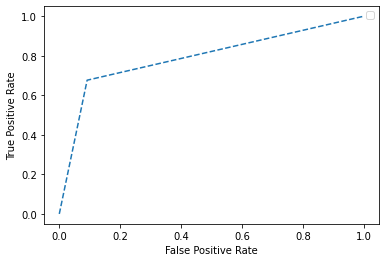

In [32]:
# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='--')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

A good measure of separability implying an excellent model is an AUC near 1. When AUC is 0.5, it means model has no class separation capacity whatsoever. Given an AUC of ~0.8, it means there is 80% chance that model will be able to distinguish between positive class (toxic) and negative class (non-toxic).


## Next Steps

Interestingly enough, the logisitic regression has poor recall while the naive bayes has poor precision. The logisitic regression classifier has an f1-score of .59 for toxic compared to the .5 f1-score of naive bayes. As such, I'm going to focus on improving recall using the Synthetic Minority Oversampling Technique (SMOTE) on the training set. In doing so, I'll be able to oversample my toxic label to, hopefully, train it better thus enabling a more accurate classifier.

# SMOTE

In [11]:
counter = Counter(ytrain)
print(counter)

Counter({0: 1245405, 1: 108250})


In [8]:
# oversample = SMOTE() with undersampling on the TRAINING SET ONLY
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_train_resample, y_train_resample = pipeline.fit_resample(Xtrain, ytrain)


In [10]:
# summarize the new class distribution
counter = Counter(y_train_resample)
print(counter)

Counter({0: 498162, 1: 249081})


The original y training set had a split of non-toxic: 1,245,405 and toxic: 108,250. Comparatively, the new SMOTE y training set has a split of non-toxic: 498,162 and toxic: 249,081. The split went from 8% toxic to 33% toxic.

## Logistic Regression

In [14]:
# Construct the LogisticRegression model
clf = LogisticRegression()

# Fit the model on the trainng data.
clf.fit(X_train_resample, y_train_resample)

# Print the accuracy from the testing data.
y_predict_test = clf.predict(Xtest)
print("\n")
print("[Test] Accuracy score (y_predict_test, ytest):",accuracy_score(y_predict_test, ytest))

y_predict_training = clf.predict(X_train_resample)
print("\n")
print("[Training] Accuracy score: (ytrain, y_predict_training)",accuracy_score(y_train_resample, y_predict_training))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)




[Test] Accuracy score (y_predict_test, ytest): 0.9215680190772109


[Training] Accuracy score: (ytrain, y_predict_training) 0.8793297494924677


In [15]:
# more comprehensive performance analysis

target_names = ['Non-Toxic', 'Toxic']

print("[Training Classification Report]")
print(classification_report(y_train_resample, y_predict_training, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(ytest, y_predict_test, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

   Non-Toxic       0.88      0.95      0.91    498162
       Toxic       0.87      0.74      0.80    249081

    accuracy                           0.88    747243
   macro avg       0.88      0.85      0.86    747243
weighted avg       0.88      0.88      0.88    747243

[Test Classification Report]
              precision    recall  f1-score   support

   Non-Toxic       0.97      0.94      0.96    415135
       Toxic       0.51      0.69      0.58     36084

    accuracy                           0.92    451219
   macro avg       0.74      0.81      0.77    451219
weighted avg       0.93      0.92      0.93    451219



 Via SMOTE, my goal was to improve the recall of my classifier. I ran my original test set through the updated logistic regression classifier and created a new classification report. In comparison to my training baseline, precision increased from 0.76 to 0.87 and recall increased from 0.48 to 0.74 with an f1-score of 0.8. On my test dataset, precision decreased from 0.74 to 0.51. Recall increased from 0.47 to 0.69. My f1-score stayed the same at 0.58.

 Typically, as precision increases, recall decreases and vice versa which we can see on our test dataset.

## Naive Bayes

In [25]:
best_alpha = 1.000000
best_min_df = 0.000010

# multinomial naive bayes classifier
nBayes = MultinomialNB(alpha=best_alpha)

# same X and y used for logistic regression
clf_nBayes = nBayes.fit(X_train_resample, y_train_resample)

accuracy_train = nBayes.score(X_train_resample,y_train_resample)
accuracy_test = nBayes.score(Xtest,ytest)

print('The training accuracy is %f and the test accuracy is %f' %(accuracy_train, accuracy_test))

The training accuracy is 0.809620 and the test accuracy is 0.816393


The gap between training and test accuracy does not imply overfitting. However, one interesting point is the training accuracy decreased from 0.929560 and the test accuracy decreased from 0.916508.

In [26]:

# Print the accuracy from the testing data.
y_predict_test = clf_nBayes.predict(Xtest)
print("\n")
print("[Test] Accuracy score (y_predict_test, ytest):",accuracy_score(y_predict_test, ytest))

y_predict_training = clf_nBayes.predict(X_train_resample)
print("\n")
print("[Training] Accuracy score: (ytrain, y_predict_training)",accuracy_score(y_train_resample, y_predict_training))




[Test] Accuracy score (y_predict_test, ytest): 0.8163929267162952


[Training] Accuracy score: (ytrain, y_predict_training) 0.8096201637218415


In [27]:
# more comprehensive performance analysis for NB

target_names = ['Non-Toxic', 'Toxic']

print("[Training Classification Report]")
print(classification_report(y_train_resample, y_predict_training, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(ytest, y_predict_test, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

   Non-Toxic       0.88      0.83      0.85    498162
       Toxic       0.69      0.78      0.73    249081

    accuracy                           0.81    747243
   macro avg       0.79      0.80      0.79    747243
weighted avg       0.82      0.81      0.81    747243

[Test Classification Report]
              precision    recall  f1-score   support

   Non-Toxic       0.98      0.82      0.89    415135
       Toxic       0.27      0.76      0.40     36084

    accuracy                           0.82    451219
   macro avg       0.62      0.79      0.65    451219
weighted avg       0.92      0.82      0.85    451219



Opposite to the logistic regression results, the non-toxic and toxic classification for both the train and test set decreased in precision, recall, and f1-score across the board. Applying SMOTE to my Naive-Bayes classifier made my model worse.

In [22]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train_resample, y_predict_training)

In [23]:
# calculate AUC
auc = roc_auc_score(y_train_resample, y_predict_training)
print('AUC: %.3f' % auc)

AUC: 0.801


No handles with labels found to put in legend.


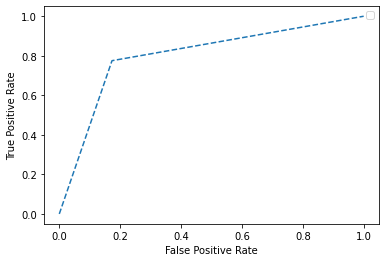

In [24]:
# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='--')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

The baseline and SMOTE AUC are both 0.8 so applying SMOTE did not change. The implication being the model's ability to distinguish between positive class (toxic) and negative class (non-toxic) did improve.


# Wrap-Up

My hypothesis was that I believed my baseline classifier would be influenced by the imbalance that exists within my original dataset. In my baseline classifiers, there is a distinct difference between both classifiers' ability to identity the toxic label which supports my hypothesis. After applying SMOTE, my logistic regression classifier became more accurate in correctly classifying the toxic label. Not only did my recall increase on my test set but both precision and recall increased on my training set. 

In comparison, the naive bayes classifier did not fare well post-SMOTE. My classifier became less accurate.

Based on the outcome of my baseline classifiers, I believe my baseline classifiers were influenced by the inherent imbalance within the data. In choosing a classifier, after my testing, I would choose the logistic regression classifier.